In [1]:
import pickle
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_ch_2_11
from src.network_utils import plot_difference_hist, compare_results

PWD = '../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 4096
LOSS_WEIGHT = 1000

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TEST_SIZE = 0.2
TRAIN_TEST_SPLIT_RANDOM_STATE = 42

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def load_model(model, name, path_component='many_channels_tests/trained_separately', root=PWD):
    model.load_weights(f'{root}/data/model_weights/{path_component}/{name}/weights')
    history = pd.read_csv(f'{root}/data/model_weights/{path_component}/{name}/loss_log.csv')

    return history

# Load optimal CFD thresholds

In [6]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.185
(1, 11): 0.200
(2,  2): 0.235
(2, 11): 0.170
(3,  2): 0.145
(3, 11): 0.195


# Test

Processing p=1, ch=2...
1/1 [==============================] - 5s 5s/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 68.37 ps (improvement: 10.49 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 39ms/step
       CFD: 87.06 ps
   optimal: 89.25 ps (improvement: -2.51 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 71ms/step
       CFD: 76.39 ps
   optimal: 72.90 ps (improvement: 4.57 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 265ms/step
       CFD: 89.17 ps
   optimal: 90.24 ps (improvement: -1.20 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 68ms/step
       CFD: 86.94 ps
   optimal: 85.19 ps (improvement: 2.02 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 89ms/step
       CFD: 111.09 ps
   optimal: 129.19 ps (improvement: -16.29 %)


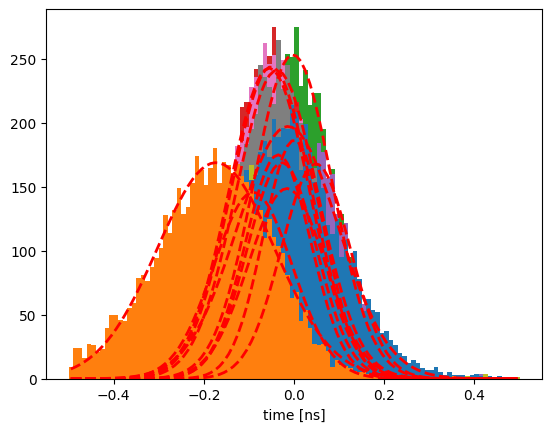

Processing p=1, ch=2...
1/1 [==============================] - 0s 155ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 72.45 ps (improvement: 5.15 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 144ms/step
       CFD: 87.06 ps
   optimal: 77.67 ps (improvement: 10.79 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 11ms/step
       CFD: 76.39 ps
   optimal: 70.23 ps (improvement: 8.06 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 156ms/step
       CFD: 89.17 ps
   optimal: 85.06 ps (improvement: 4.60 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 11ms/step
       CFD: 86.94 ps
   optimal: 90.84 ps (improvement: -4.49 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 21ms/step
       CFD: 111.09 ps
   optimal: 112.49 ps (improvement: -1.26 %)


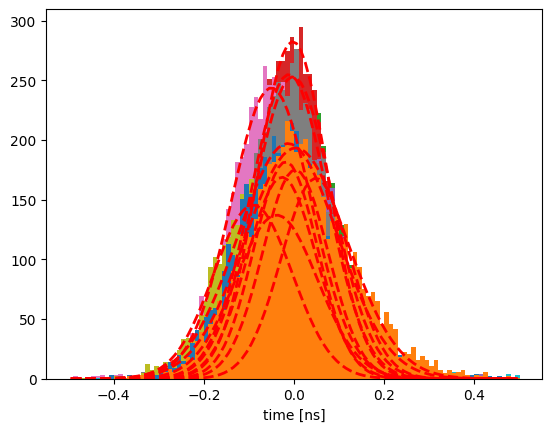

Processing p=1, ch=2...
1/1 [==============================] - 0s 137ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 71.27 ps (improvement: 6.70 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 135ms/step
       CFD: 87.06 ps
   optimal: 80.22 ps (improvement: 7.86 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 11ms/step
       CFD: 76.39 ps
   optimal: 66.47 ps (improvement: 12.99 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 15ms/step
       CFD: 89.17 ps
   optimal: 85.00 ps (improvement: 4.68 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 12ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


       CFD: 86.94 ps
   optimal: 89.31 ps (improvement: -2.73 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 124ms/step
       CFD: 111.09 ps
   optimal: 105.26 ps (improvement: 5.25 %)


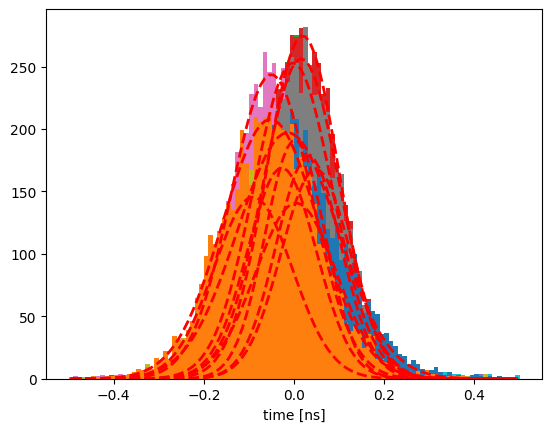

Processing p=1, ch=2...
1/1 [==============================] - 0s 147ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 72.08 ps (improvement: 5.64 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 140ms/step
       CFD: 87.06 ps
   optimal: 82.94 ps (improvement: 4.73 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 13ms/step
       CFD: 76.39 ps
   optimal: 70.41 ps (improvement: 7.83 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 42ms/step
       CFD: 89.17 ps
   optimal: 83.32 ps (improvement: 6.56 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 12ms/step
       CFD: 86.94 ps
   optimal: 83.64 ps (improvement: 3.80 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 145ms/step
       CFD: 111.09 ps
   optimal: 104.30 ps (improvement: 6.11 %)


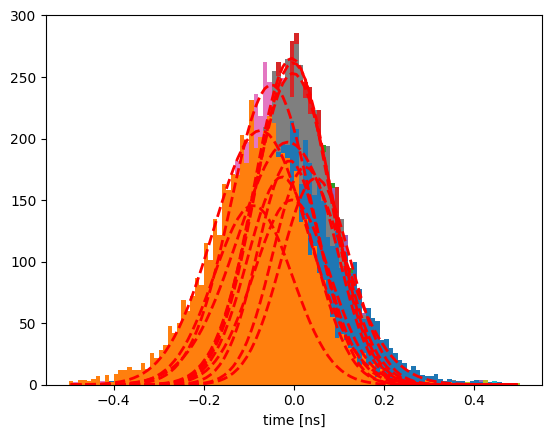

Processing p=1, ch=2...
1/1 [==============================] - 0s 138ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 70.17 ps (improvement: 8.14 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 42ms/step
       CFD: 87.06 ps
   optimal: 102.29 ps (improvement: -17.49 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 11ms/step
       CFD: 76.39 ps
   optimal: 78.11 ps (improvement: -2.24 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 229ms/step
       CFD: 89.17 ps
   optimal: 90.31 ps (improvement: -1.28 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 12ms/step
       CFD: 86.94 ps
   optimal: 77.14 ps (improvement: 11.27 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 16ms/step
       CFD: 111.09 ps
   optimal: 124.99 ps (improvement: -12.51 %)


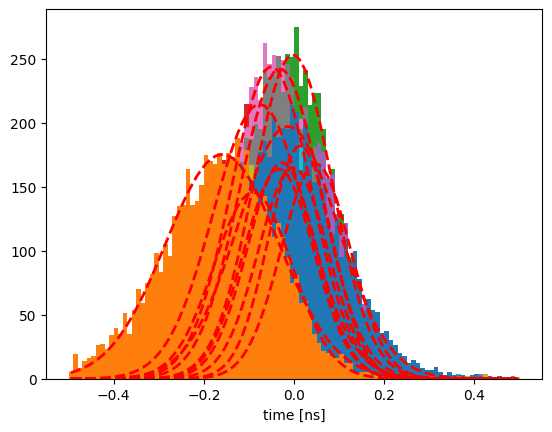

Processing p=1, ch=2...
1/1 [==============================] - 0s 240ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 76.38 ps
   optimal: 81.41 ps (improvement: -6.58 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 129ms/step
       CFD: 87.06 ps
   optimal: 84.71 ps (improvement: 2.70 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 12ms/step
       CFD: 76.39 ps
   optimal: 73.22 ps (improvement: 4.15 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 122ms/step
       CFD: 89.17 ps
   optimal: 86.41 ps (improvement: 3.10 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 12ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


       CFD: 86.94 ps
   optimal: 93.18 ps (improvement: -7.17 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 25ms/step
       CFD: 111.09 ps
   optimal: 93.91 ps (improvement: 15.47 %)


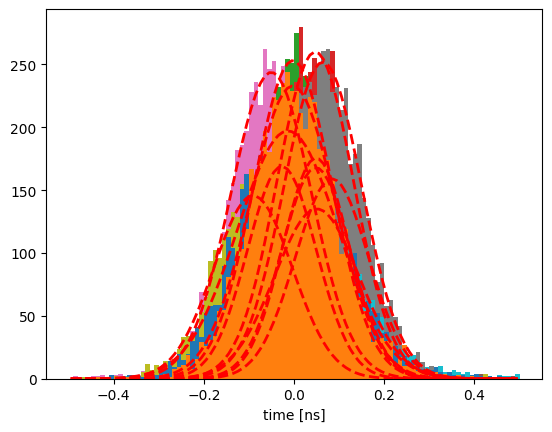

In [7]:
results = {}
for model_plane, model_channel in list(dataset.keys()):
    display(HTML(f'<h3>Loading model p={model_plane}, ch={model_channel}...</h3>'))
    model = optimal_model_builder_ch_2_11()
    load_model(model, f'optimal_{model_plane}_{model_channel}')

    this_results = {}
    for (plane, channel), (all_X, all_y) in dataset.items():
        print(f'Processing p={plane}, ch={channel}...')
        _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE,
                                                random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

        cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
        y_pred_cfd = cfd.predict(X_TIME, X_test)
        std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

        y_pred_model = model_predict(model, X_test)
        std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

        compare_results([std_model], ["optimal"], std_cfd)
        this_results[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)  # cfd, model, improv

    plt.show()
    results[(model_plane, model_channel)] = this_results

# Analyse results

In [8]:
# Check that the order is the same
assert list(results.keys()) == sorted(results.keys())
for x in results.values():
    assert list(x.keys()) == sorted(x.keys())

row_names = [str(key) for key in results.keys()]
col_names = [str(key) for key in list(results.values())[0].keys()]

In [9]:
improv_data = np.array([list(str(f'{x[2] * 100:0.2f} %') for x in r.values()) for r in results.values()])

In [10]:
df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on / tested on'
df

,"(1, 2)","(1, 11)","(2, 2)","(2, 11)","(3, 2)","(3, 11)"
trained on / tested on,,,,,,
"(1, 2)",10.49 %,-2.51 %,4.57 %,-1.20 %,2.02 %,-16.29 %
"(1, 11)",5.15 %,10.79 %,8.06 %,4.60 %,-4.49 %,-1.26 %
"(2, 2)",6.70 %,7.86 %,12.99 %,4.68 %,-2.73 %,5.25 %
"(2, 11)",5.64 %,4.73 %,7.83 %,6.56 %,3.80 %,6.11 %
"(3, 2)",8.14 %,-17.49 %,-2.24 %,-1.28 %,11.27 %,-12.51 %
"(3, 11)",-6.58 %,2.70 %,4.15 %,3.10 %,-7.17 %,15.47 %
